# Description

项目介绍及数据来源见 Kaggle：[Spaceship Titanic](https://www.kaggle.com/competitions/spaceship-titanic/overview)。

数据详情：

- `data.csv` 训练集样本量约为 8700 人；
- 数据字段详情：
  - 数据字段共有 14 个；
  - 字段详情：
    - `PassengerId`：每个乘客的唯一标识。其形式为 `gggg_pp`，其中 `gggg` 表示乘客一同乘坐的团体，`pp` 是他们在团体中的编号。团体中的个人通常是家庭成员，**但这也不是绝对的**；
    - `HomePlanet`：乘客所离开的星球，通常是他们永久居住的星球；
    - `CryoSleep`：表示乘客是否选择在航行期间进入深度睡眠，处于深度睡眠状态的乘客被限制在他们坐在的船舱内；
    - `Cabin`：乘客所住的船舱及座位号，采取 `甲板/编号/侧面` 的形式编号，其中侧面的 P 代表左舷（船身左半边），S 代表右舷（船身右半边）；
    - `Destination`：乘客此次航行的目的地；
    - `Age`：乘客的年龄；
    - `VIP`：乘客是否为 VIP；
    - `RoomService`，`FoodCourt`，`ShoppingMall`，`Spa`，`VRDeck`：即乘客在太空船的众多豪华设施项中的**花销金额**；
    - `Name`：乘客的名字和姓氏；
    - `Transported`：乘客是否被运送到另一个空间，**这也是训练集的参考答案以及需要在测试集中预测的结果**。


In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "svg"

In [2]:
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# figure settings
sns.set_theme()
plt.rcParams["axes.unicode_minus"] = False

## Utilities Definition

In [3]:
# use dict to store handled features
features = {}

In [4]:
def make_frequency(df, column, as_percent=True, use_total=True, **kwargs):
    """
    create the report table about the target column with 
    frequency, percentage and total information
    """
    
    percent = pd.Series(dtype="object")
    data = []
    opts = dict(dropna=False)

    
    if kwargs:
        if kwargs.get("normalize"):
            kwargs.pop("normalize")
            
        opts.update(kwargs)
    
    base = df[column].value_counts(**opts).to_frame(name="N")
    data.append(base)
    
    if as_percent:
        opts["normalize"] = True
        percent = df[column].value_counts(**opts).to_frame(name="%")
        data.append(percent)

    report = pd.concat(data, join="inner", axis="columns")
    
    if use_total:
        total = report.sum().to_frame().transpose().set_index(pd.Index(["Total"]))
        report = pd.concat([report, total])

    if "%" in report.columns:
        report["%"] = report["%"].map(lambda v: f"{v*100:.2f}%")
    
    report.index.name = column
    return report.astype({"N": pd.Int64Dtype()})


In [5]:
def both_direction_fill(df, na_group, like):
    filled = (
        df.query(f"Group.isin(@na_group)")
        .groupby("Group")
        .apply(
            lambda grp: grp.filter(like=f"{like}")
            .fillna(method="bfill")
            .fillna(method="ffill")
        )
    )
    return filled

# Data Explore

In [6]:
data = pd.read_csv("../../data/spaceship-titanic/data.csv").set_index("PassengerId", drop=False)
data.head()

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
PassengerId                                                                     
0001_01         0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
0002_01         0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
0003_01         0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
0003_02         0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
0004_01         0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

             RoomService  FoodCourt  ShoppingMall     Spa  VRDeck  \
PassengerId                                                         
0001_01              0.0        0.0           0.0     0.0     0.0   
0002_01            109.0        9.0          25.0   549.0    44.0   
0003_01             43.0     3576.0           0.0  6715.0    49.0   
0003_02              0.0     1283.0         371.0  3329.0   193.0   
0004_01            303.0       70.0         151.0   565.0     2.0   

                          Name  Transported  
PassengerId                                  
0001_01        Maham Ofracculy        False  
0002_01           Juanna Vines         True  
0003_01          Altark Susent        False  
0003_02           Solam Susent        False  
0004_01      Willy Santantines         True

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 959.3+ KB


In [8]:
data.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

## Categorical Fields

### HomePlanet counter

In [9]:
make_frequency(data, "HomePlanet")

N        %
HomePlanet               
Earth       4602   52.94%
Europa      2131   24.51%
Mars        1759   20.23%
NaN          201    2.31%
Total       8693  100.00%

### CryoSleep counter

In [10]:
make_frequency(data, "CryoSleep")

N        %
CryoSleep               
False      5439   62.57%
True       3037   34.94%
NaN         217    2.50%
Total      8693  100.00%

### Cabin counter

In [11]:
make_frequency(data, "Cabin")

N        %
Cabin                 
NaN       199    2.29%
G/734/S     8    0.09%
C/137/S     7    0.08%
B/201/P     7    0.08%
G/109/P     7    0.08%
...       ...      ...
E/231/S     1    0.01%
G/545/S     1    0.01%
G/543/S     1    0.01%
C/178/S     1    0.01%
Total    8693  100.00%

[6562 rows x 2 columns]

### Destination counter

In [12]:
make_frequency(data, "Destination")

N        %
Destination                 
TRAPPIST-1e    5915   68.04%
55 Cancri e    1800   20.71%
PSO J318.5-22   796    9.16%
NaN             182    2.09%
Total          8693  100.00%

### VIP counter

In [13]:
make_frequency(data, "VIP")

N        %
VIP                 
False  8291   95.38%
NaN     203    2.34%
True    199    2.29%
Total  8693  100.00%

### Transported counter

In [14]:
make_frequency(data, "Transported")

N        %
Transported               
True         4378   50.36%
False        4315   49.64%
Total        8693  100.00%

### Drop name

**improved: can guess the gender from name**

In [15]:
data["Name"].head()

PassengerId
0001_01      Maham Ofracculy
0002_01         Juanna Vines
0003_01        Altark Susent
0003_02         Solam Susent
0004_01    Willy Santantines
Name: Name, dtype: object

## Numerical Fields

In [16]:
numeric = data.select_dtypes(include="number")
numeric.head()

Age  RoomService  FoodCourt  ShoppingMall     Spa  VRDeck
PassengerId                                                            
0001_01      39.0          0.0        0.0           0.0     0.0     0.0
0002_01      24.0        109.0        9.0          25.0   549.0    44.0
0003_01      58.0         43.0     3576.0           0.0  6715.0    49.0
0003_02      33.0          0.0     1283.0         371.0  3329.0   193.0
0004_01      16.0        303.0       70.0         151.0   565.0     2.0

In [17]:
numeric.describe()

Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  8514.000000   8512.000000   8510.000000   8485.000000   8510.000000   
mean     28.827930    224.687617    458.077203    173.729169    311.138778   
std      14.489021    666.717663   1611.489240    604.696458   1136.705535   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%      19.000000      0.000000      0.000000      0.000000      0.000000   
50%      27.000000      0.000000      0.000000      0.000000      0.000000   
75%      38.000000     47.000000     76.000000     27.000000     59.000000   
max      79.000000  14327.000000  29813.000000  23492.000000  22408.000000   

             VRDeck  
count   8505.000000  
mean     304.854791  
std     1145.717189  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%       46.000000  
max    24133.000000

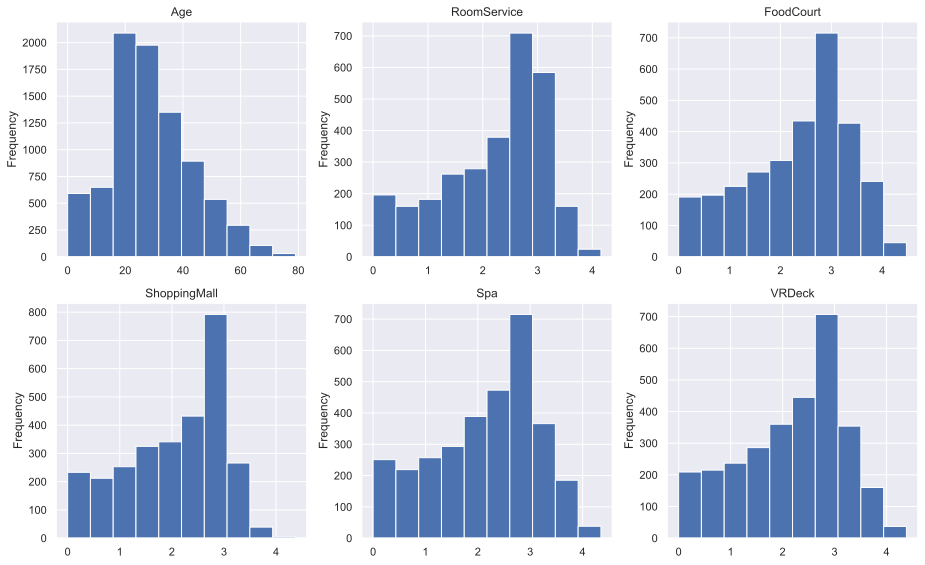

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(13, 8))


for column, ax in zip(numeric.columns, itertools.chain(*axes)):
    df = numeric[column]
    if column != "Age":
        df = df[df>0].transform(np.log10)
    df.plot.hist(ax=ax, title=f"{column}")

plt.tight_layout()

In [19]:
services = (
    numeric.drop("Age", axis=1)
    .assign(TotalServiceFee=lambda r: r.sum(axis=1))
    .fillna(0)
    .add(1)
)

In [20]:
services = services.transform(np.log10).join(data["Transported"])

In [21]:
services.head()

RoomService  FoodCourt  ShoppingMall       Spa    VRDeck  \
PassengerId                                                             
0001_01         0.000000   0.000000      0.000000  0.000000  0.000000   
0002_01         2.041393   1.000000      1.414973  2.740363  1.653213   
0003_01         1.643453   3.553519      0.000000  3.827111  1.698970   
0003_02         0.000000   3.108565      2.570543  3.522444  2.287802   
0004_01         2.482874   1.851258      2.181844  2.752816  0.477121   

             TotalServiceFee  Transported  
PassengerId                                
0001_01             0.000000        False  
0002_01             2.867467         True  
0003_01             4.016365        False  
0003_02             3.714078        False  
0004_01             3.038223         True

In [22]:
g = sns.PairGrid(data=services.drop("TotalServiceFee", axis=1).sample(frac=0.05), hue="Transported")
g.map_upper(sns.regplot)
g.map_diag(sns.kdeplot)
g.map_lower(sns.kdeplot, fill=True)
g.add_legend()

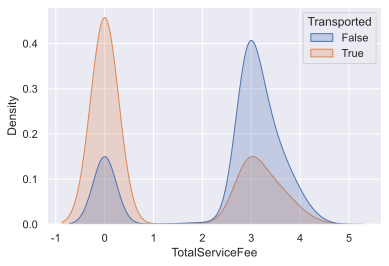

In [23]:
ax = sns.kdeplot(data=services, x="TotalServiceFee", hue="Transported", fill=True)

# Feature Engineering

## Data type convert

In [24]:
types = dict(
    # convert object, boolean to StringDtype
    PassengerId="string",
    HomePlanet="string",
    Cabin="string",
    Destination="string",
    Name="string",
    CryoSleep="string",
    VIP="string",
    Transported="string",
    
    # convert Age to Int64Dytype to avoid
    # being float type because of NA.
    Age=pd.Int64Dtype(),

)

data = data.astype(types)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   string 
 1   HomePlanet    8492 non-null   string 
 2   CryoSleep     8476 non-null   string 
 3   Cabin         8494 non-null   string 
 4   Destination   8511 non-null   string 
 5   Age           8514 non-null   Int64  
 6   VIP           8490 non-null   string 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   string 
 13  Transported   8693 non-null   string 
dtypes: Int64(1), float64(5), string(8)
memory usage: 1.3+ MB


## PassengerId Group Extraction

- Is single group or not
- Merge raw data by `PassengerId`

In [25]:
passenger_group = (
    data["PassengerId"]
    .str.extract("(?P<Group>\d{4})_", expand=True)
    .reset_index()
)
passenger_group.head(5)

PassengerId Group
0     0001_01  0001
1     0002_01  0002
2     0003_01  0003
3     0003_02  0003
4     0004_01  0004

<AxesSubplot:ylabel='Frequency'>

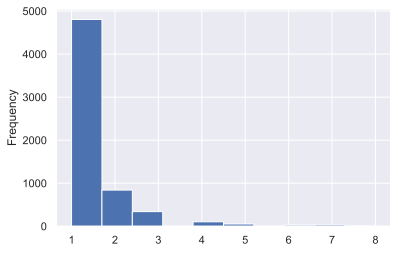

In [26]:
passenger_group.value_counts("Group").plot.hist()

In [27]:
is_single_group = passenger_group.value_counts("Group").eq(1).to_frame(name="IsSingleGroup").reset_index()
is_single_group.head()

Group  IsSingleGroup
0  4498          False
1  8168          False
2  8728          False
3  8796          False
4  8956          False

In [28]:
make_frequency(is_single_group, "IsSingleGroup", as_percent=True)

N        %
IsSingleGroup               
True           4805   77.29%
False          1412   22.71%
Total          6217  100.00%

In [29]:
passenger_group = (
    passenger_group
    .merge(is_single_group, on="Group", how="left")
    .set_index("PassengerId")
)
passenger_group.head()

Group  IsSingleGroup
PassengerId                     
0001_01      0001           True
0002_01      0002           True
0003_01      0003          False
0003_02      0003          False
0004_01      0004           True

In [30]:
features["passenger_group"] = passenger_group.astype("string")

## Split Cabin Code

In [31]:
cabin = data["Cabin"].str.split(r"/", expand=True).rename(columns={0: "CabinDesk", 1: "CabinNumber", 2: "CabinSide"})
cabin.head()

CabinDesk CabinNumber CabinSide
PassengerId                                
0001_01             B           0         P
0002_01             F           0         S
0003_01             A           0         S
0003_02             A           0         S
0004_01             F           1         S

In [32]:
make_frequency(cabin, "CabinDesk")

N        %
CabinDesk               
F          2794   32.14%
G          2559   29.44%
E           876   10.08%
B           779    8.96%
C           747    8.59%
D           478    5.50%
A           256    2.94%
<NA>        199    2.29%
T             5    0.06%
Total      8693  100.00%

In [33]:
make_frequency(cabin, "CabinNumber")

N        %
CabinNumber               
<NA>          199    2.29%
82             28    0.32%
86             22    0.25%
19             22    0.25%
56             21    0.24%
...           ...      ...
1797            1    0.01%
1754            1    0.01%
1723            1    0.01%
1894            1    0.01%
Total        8693  100.00%

[1819 rows x 2 columns]

In [34]:
cabin["IsEvenCabinNumber"] = cabin["CabinNumber"].astype(pd.Int64Dtype()).map(lambda v: v%2==0).astype("string")

In [35]:
make_frequency(cabin, "IsEvenCabinNumber")

N        %
IsEvenCabinNumber               
False              4285   49.29%
True               4209   48.42%
<NA>                199    2.29%
Total              8693  100.00%

In [36]:
cabin = cabin.drop("CabinNumber", axis=1)

In [37]:
make_frequency(cabin, "CabinSide", as_percent=True)

N        %
CabinSide               
S          4288   49.33%
P          4206   48.38%
<NA>        199    2.29%
Total      8693  100.00%

In [38]:
features["cabin"] = cabin

In [39]:
data.head()

PassengerId HomePlanet CryoSleep  Cabin  Destination  Age    VIP  \
PassengerId                                                                    
0001_01         0001_01     Europa     False  B/0/P  TRAPPIST-1e   39  False   
0002_01         0002_01      Earth     False  F/0/S  TRAPPIST-1e   24  False   
0003_01         0003_01     Europa     False  A/0/S  TRAPPIST-1e   58   True   
0003_02         0003_02     Europa     False  A/0/S  TRAPPIST-1e   33  False   
0004_01         0004_01      Earth     False  F/1/S  TRAPPIST-1e   16  False   

             RoomService  FoodCourt  ShoppingMall     Spa  VRDeck  \
PassengerId                                                         
0001_01              0.0        0.0           0.0     0.0     0.0   
0002_01            109.0        9.0          25.0   549.0    44.0   
0003_01             43.0     3576.0           0.0  6715.0    49.0   
0003_02              0.0     1283.0         371.0  3329.0   193.0   
0004_01            303.0       70.0         151.0   565.0     2.0   

                          Name Transported  
PassengerId                                 
0001_01        Maham Ofracculy       False  
0002_01           Juanna Vines        True  
0003_01          Altark Susent       False  
0003_02           Solam Susent       False  
0004_01      Willy Santantines        True

## Merge all data together

In [40]:
dropped = [
    "PassengerId",
    "Cabin", 
    "Name", 
]

data = pd.concat([data, *features.values()], axis="columns").drop(dropped, axis=1)
data.head()

HomePlanet CryoSleep  Destination  Age    VIP  RoomService  \
PassengerId                                                              
0001_01         Europa     False  TRAPPIST-1e   39  False          0.0   
0002_01          Earth     False  TRAPPIST-1e   24  False        109.0   
0003_01         Europa     False  TRAPPIST-1e   58   True         43.0   
0003_02         Europa     False  TRAPPIST-1e   33  False          0.0   
0004_01          Earth     False  TRAPPIST-1e   16  False        303.0   

             FoodCourt  ShoppingMall     Spa  VRDeck Transported Group  \
PassengerId                                                              
0001_01            0.0           0.0     0.0     0.0       False  0001   
0002_01            9.0          25.0   549.0    44.0        True  0002   
0003_01         3576.0           0.0  6715.0    49.0       False  0003   
0003_02         1283.0         371.0  3329.0   193.0       False  0003   
0004_01           70.0         151.0   565.0     2.0        True  0004   

            IsSingleGroup CabinDesk CabinSide IsEvenCabinNumber  
PassengerId                                                      
0001_01              True         B         P              True  
0002_01              True         F         S              True  
0003_01             False         A         S              True  
0003_02             False         A         S              True  
0004_01              True         F         S             False

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   HomePlanet         8492 non-null   string 
 1   CryoSleep          8476 non-null   string 
 2   Destination        8511 non-null   string 
 3   Age                8514 non-null   Int64  
 4   VIP                8490 non-null   string 
 5   RoomService        8512 non-null   float64
 6   FoodCourt          8510 non-null   float64
 7   ShoppingMall       8485 non-null   float64
 8   Spa                8510 non-null   float64
 9   VRDeck             8505 non-null   float64
 10  Transported        8693 non-null   string 
 11  Group              8693 non-null   string 
 12  IsSingleGroup      8693 non-null   string 
 13  CabinDesk          8494 non-null   string 
 14  CabinSide          8494 non-null   string 
 15  IsEvenCabinNumber  8494 non-null   string 
dtypes: Int64(1), float64

## Filling homeplanet records by passenager group

In [42]:
homeplanet_na_group = data.groupby("Group").filter(lambda grp: len(grp)>=2).query("HomePlanet.isna()")["Group"]
homeplanet_na_group

PassengerId
0064_02    0064
0119_01    0119
0444_02    0444
0445_02    0445
0470_02    0470
           ... 
8938_01    8938
8961_04    8961
9030_02    9030
9072_01    9072
9194_01    9194
Name: Group, Length: 92, dtype: string

In [43]:
filled_homeplanet = both_direction_fill(data, homeplanet_na_group, like="Planet")
filled_homeplanet.head(10)

HomePlanet
PassengerId           
0064_01           Mars
0064_02           Mars
0119_01         Europa
0119_02         Europa
0444_01           Mars
0444_02           Mars
0445_01          Earth
0445_02          Earth
0470_01           Mars
0470_02           Mars

In [44]:
data.loc[filled_homeplanet.index, filled_homeplanet.columns] = filled_homeplanet

In [45]:
data.query("Group=='0119'")

HomePlanet CryoSleep  Destination  Age    VIP  RoomService  \
PassengerId                                                              
0119_01         Europa     False  TRAPPIST-1e   39  False          0.0   
0119_02         Europa      True  TRAPPIST-1e   13  False          0.0   

             FoodCourt  ShoppingMall   Spa  VRDeck Transported Group  \
PassengerId                                                            
0119_01         2344.0           0.0  65.0  6898.0       False  0119   
0119_02            0.0           0.0   0.0     0.0        True  0119   

            IsSingleGroup CabinDesk CabinSide IsEvenCabinNumber  
PassengerId                                                      
0119_01             False         A         P              True  
0119_02             False         A         P              True

## Filling cabin records by passenager group

In [46]:
cabin_na_group = data.groupby("Group").filter(lambda grp: len(grp)>=2).query("IsEvenCabinNumber.isna()")["Group"]

In [47]:
filled_cabin = both_direction_fill(data, cabin_na_group, like="Cabin")
filled_cabin

CabinDesk CabinSide IsEvenCabinNumber
PassengerId                                      
0110_01             B         P             False
0110_02             B         P             False
0110_03             B         P             False
0110_04             B         P             False
0244_01             F         S             False
...               ...       ...               ...
9081_04             G         P              True
9081_05             F         P              True
9081_06             F         P              True
9081_07             G         P              True
9081_08             G         P              True

[347 rows x 3 columns]

In [48]:
data.loc[filled_cabin.index, filled_cabin.columns] = filled_cabin

## Tidy data

In [49]:
codes = (
    data.drop(["Group"], axis=1)
    .select_dtypes(exclude="number")
    .fillna("Unknown")
)
data.loc[:, codes.columns] = codes

In [50]:
data = data.dropna(subset=["Age"])

In [51]:
service_cols = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]
data.loc[:, service_cols] = data[service_cols].fillna(1).add(1).transform(np.log10)

In [52]:
data.isna().sum()

HomePlanet           0
CryoSleep            0
Destination          0
Age                  0
VIP                  0
RoomService          0
FoodCourt            0
ShoppingMall         0
Spa                  0
VRDeck               0
Transported          0
Group                0
IsSingleGroup        0
CabinDesk            0
CabinSide            0
IsEvenCabinNumber    0
dtype: int64

# Work with Scikit-learn

In [53]:
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline

X = data.drop(["Group", "Transported"], axis=1).reset_index(drop=True)
y = data["Transported"].map({"False":0, "True": 1})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=233)

In [54]:
categorical_cols = X.select_dtypes(exclude="number").columns
numeric_cols = X.select_dtypes(include="number").columns

transformer = ColumnTransformer(
    transformers=[
        ("categorical_feature", OrdinalEncoder(), categorical_cols),
        ("numeric_feature", StandardScaler(), numeric_cols),
    ]
)

# Training and Build Classification Model

In [55]:
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pipe = Pipeline(
    steps=[
        ("preprocessor", transformer),
        ("model", RandomForestClassifier()),
    ]
)


param_grid=dict(
    model__n_estimators=[50, 100, 150],
    model__criterion=["gini", "entropy"],
    model__max_depth=[3, 5, 7],
    
)

gscv = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=10,
    verbose=1,
    n_jobs=os.cpu_count()-2,
)

gscv.fit(X_train, y_train)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('categorical_feature',
                                                                         OrdinalEncoder(),
                                                                         Index(['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'IsSingleGroup',
       'CabinDesk', 'CabinSide', 'IsEvenCabinNumber'],
      dtype='object')),
                                                                        ('numeric_feature',
                                                                         StandardScaler(),
                                                                         Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], dtype='object'))])),
                                       ('model', RandomForestClassifier())]),
             n_jobs=14,
             param_grid={'model__criterion': ['gini', 'en

In [56]:
gscv.score(X_test, y_test)

0.799177921315326

In [57]:
from sklearn.metrics import classification_report

y_pred = gscv.predict(X_test)

print(classification_report(y_test,y_pred,  target_names=["No transported", "Transported"]))

                precision    recall  f1-score   support

No transported       0.82      0.77      0.79       856
   Transported       0.78      0.83      0.80       847

      accuracy                           0.80      1703
     macro avg       0.80      0.80      0.80      1703
  weighted avg       0.80      0.80      0.80      1703



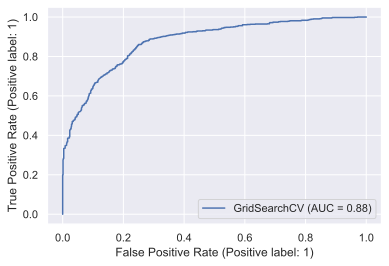

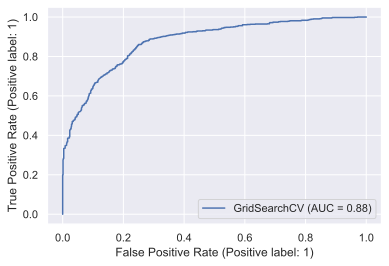

In [58]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(gscv, X_test, y_test).plot()

plt.savefig('05-model-roc.png', dpi=300)

In [59]:
gscv.best_params_

{'model__criterion': 'gini', 'model__max_depth': 7, 'model__n_estimators': 100}

In [60]:
pipe.set_params(**gscv.best_params_)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical_feature',
                                                  OrdinalEncoder(),
                                                  Index(['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'IsSingleGroup',
       'CabinDesk', 'CabinSide', 'IsEvenCabinNumber'],
      dtype='object')),
                                                 ('numeric_feature',
                                                  StandardScaler(),
                                                  Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], dtype='object'))])),
                ('model', RandomForestClassifier(max_depth=7))])

In [61]:
import joblib

joblib.dump(pipe, "spaceship-titanic.model")

['spaceship-titanic.model']